# Media Effect Estimation with the KTR Orbit Model

In this notebook we want to experiment to the new [KTR model](https://orbit-ml.readthedocs.io/en/stable/tutorials/ktr1.html) included in the new [`orbit`](https://github.com/uber/orbit)'s release [(1.1)](https://github.com/uber/orbit/releases/tag/v1.1.0). In particular, we are interested in its applications to media effects estimation in the context of media mix modeling. This is one of the applications for the KTR model by the Uber's team, see the corresponding paper [Edwin, Ng, et al. "Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling"](https://arxiv.org/abs/2106.03322).

KTR stands for *kernel-based Time-varying regression* as its main feature is to fit time-variant regression coefficients in a bayesian forecasting model. For details on the KTR model, see the paper mentioned above and  [KTR documentation](https://orbit-ml.readthedocs.io/en/stable/tutorials/ktr1.html) where there is a great sequence of tutorials. In a nutshell, given a time series $y_t$ the KTR models its components as $y_t = l_t + s_t + r_t + \varepsilon_t$, where $l_t$ is the local-trend (level) , $s_t$ is the seasonal component, $r_t$ are the regression terms and $\varepsilon_t$ is a stationary random error process. This is very similar to the [Prophet](https://facebook.github.io/prophet/) model (we actually compare these two models bellow). One of the main differences is that the regression coefficients are time-varying. From the model documentation: 

> *The core of KTR is the use of latent variables to define a smooth time varying representation of model coefficients. These smooth representations are [Kernel Smooths](https://en.wikipedia.org/wiki/Kernel_smoother).*

These *latent variables* are somehow similar (or at least inspired) to the basis functions in a spline regression. Again, for details see the references above (which is **strongly** recommended!).

This notebook has two parts:
- In **Part I** we generate the data ourselves. This allow us to have control on the data generation process in order to understand the strength and limitations of the KTR model. Moreover, we explore useful transformations of media cost data to model carryover and diminishing returns, see [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017)](https://research.google/pubs/pub46001/).
- In **Part II** we use the KTR model to estimate the media effects. We also compare it with a baseline [Prophet](https://facebook.github.io/prophet/) model.

**Remark**: In many applications measuring the effects via regression analysis is challenging because potential stochastic factors between the input and response variable. In our work [Modelling stochastic time delay for regression analysis](https://arxiv.org/abs/2111.06403) with Aaron Pickering we go deeper into this subject.

## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from orbit.models import KTR
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from scipy.ndimage import gaussian_filter
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext rich
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [2]:
# let us get orbit version
! pip list | grep -i "orbit"

orbit-ml                     1.1.1.dev0 /Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/src/orbit-ml


---
## Part I:  Generate Sample Data

We are going to generate a sample data set. The main idea is to generate a time series $y$ which will represent target variable, lets say *sales*. This time series will consist of various components: a trend, a seasonal component, an external regressor and some gaussian noise. We will describe the components in more detail below. For now, let us tart by generating the data range: $3$ years of weekly data.

In [3]:
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

data_df = data_df.assign(
    year = lambda x: x["date"].dt.year,
    month = lambda x: x["date"].dt.month,
    dayofyear = lambda x: x["date"].dt.dayofyear,
)

n = data_df.shape[0]

### Media Cost Features

- **Generate Media Cost Feature**

Let us start by defining the external regressor: a media cost feature. This variable will play the role of sales driver for our target variable. In practice, the marketing manager will have control over this variable. In this example we use a uniform distribution to simulate it.

<Figure size 1000x600 with 1 Axes>

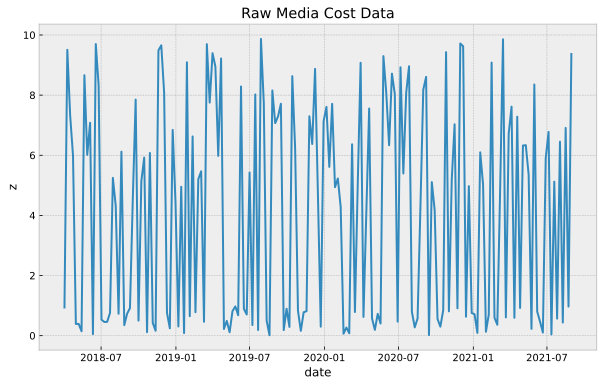

In [4]:
SEED = 42
np.random.seed(SEED)

# sample from a uniform distribution on [0, 1] and cutand some threshold (0.4)
z = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z"] = 10 * np.where( z > 0.4, z, z/4)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="z", data=data_df, ax=ax)
ax.set(title="Raw Media Cost Data");

- *Adstock Transformation*

Next we apply an [adstock transformation](https://en.wikipedia.org/wiki/Advertising_adstock) to the media cost feature. This transformation aims to model the carry over effect of media spend. See [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017)](https://research.google/pubs/pub46001/) for more details.

**Remark:** In practice we would like to *learn* the adstock curve from the data. This can be done with [PyMC](https://docs.pymc.io/en/v3/) as illustrated in the blog post [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a). This approach was also used in HelloFresh's Media Mix Model, as presented in the following resources:
- Article: [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6) 
- Video: [A Bayesian Approach to Media Mix Modeling by Michael Johns & Zhenyu Wang](https://www.youtube.com/watch?v=UznM_-_760Y)
- Articles: [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/) and [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/) by [PyMC Labs](https://www.pymc-labs.io/)

For this specific example we are going to assume a certain heuristic for the adstock curve, and hence it will not be part of the model. We are going to apply a *geometric adstock transformation*, which is defined by the following transformer:

In [5]:
class GeometricAdstockTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, alpha: float = 0.0, l: int = 12):
        self.alpha = alpha
        self.l = l

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        cycles = [
            np.append(
                arr=np.zeros(shape=x.shape)[:i],
                values=x[: x.shape[0] - i],
                axis=0
            ) 
            for i in range(self.l)
        ]
        x_cycle = np.stack(cycles, axis=0)
        w = np.array([np.power(self.alpha, i) for i in range(self.l)])
        return np.tensordot(a=w, b=x_cycle, axes=1)

Next, lets apply the adstock transformation to the media cost feature.

In [6]:
# the effect carryover factor is 1/2 (usual assumption)
alpha = 1/2
# The carryover period is 12 weeks, which is also quite reasonable.
l = 12 

geometric_adstock_transformer = GeometricAdstockTransformer(alpha=alpha, l=l)

data_df["z_adstock"] = geometric_adstock_transformer.fit_transform(data_df["z"])

Let us plot the transformed data:

<Figure size 1000x600 with 2 Axes>

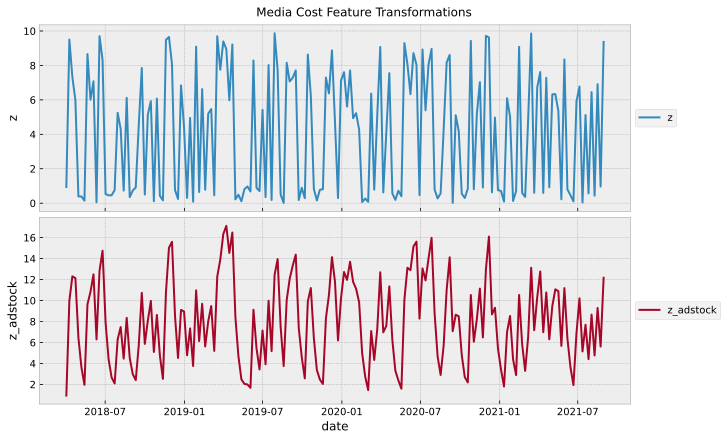

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, layout="constrained")

features = ["z", "z_adstock"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

- **Saturation Transformation:**

Now we apply a saturation transformation to the media cost feature, which should capture the non-linear effect of media in sales (otherwise the marketing manager would just spending more and more to increase sales, but experience and intuition shows the relation is non-linear and eventually saturates). There are many possible parametrizations for such a transformation, but we will use the following one:

$$
x\longmapsto \frac{1 - e^{-\mu x}}{1 + e^{-\mu x}}
$$

Let us implement the corresponding transformer:

In [8]:
class LogisticSaturationTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, mu: float = 0.5):
        self.mu = mu

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return (1 - np.exp(-self.mu * x)) / (1 + np.exp(-self.mu * x))

We can now apply the saturation transformation to the (adstock) media cost feature.

In [9]:
mu = 1.5e-1

logistic_saturation_transformer = LogisticSaturationTransformer(mu=mu)

data_df["z_adstock_saturated"] = logistic_saturation_transformer.fit_transform(data_df["z_adstock"])

We will not use `z_adstock_saturated` in our model and we would like to recover the saturation effect. Let us plot the saturation curve:

<Figure size 700x600 with 1 Axes>

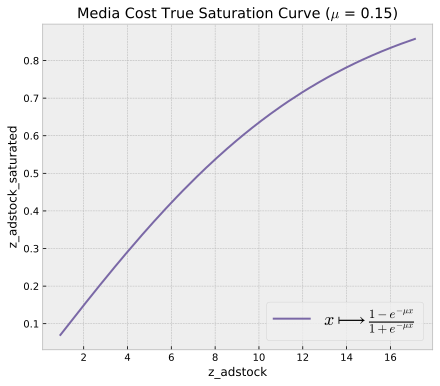

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\mu x}}{1 + e^{-\mu x}}$"
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 18})
ax.set(title=f"Media Cost True Saturation Curve ($\mu$ = {mu})");

Note that the saturation curve is almost linear for values `z_adstock` < $6$. After this point the first derivative starts to decrease.

**Remark:** It is clear that the adstock and saturation transformations do not commute (i.e. the order matters). Which one to apply first? Following [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017)](https://research.google/pubs/pub46001/) , section 2.3:
> *We could first apply the adstock transformation to the time series of media spend, and then apply
the shape transformation. An alternative way would be to reverse the order. If media spend in
each time period is relatively small compared to the cumulative spend across multiple time periods,
the shape effect in each time period is less obvious compared to that of cumulative media spend.
In this case, we would prefer to apply the shape transformation after the adstock transformation.
However, if the media spend is heavily concentrated in some single time periods with an on-and-off
pattern, the latter choice might be preferable.*

Let us now plot all the transformations:

<Figure size 1000x600 with 3 Axes>

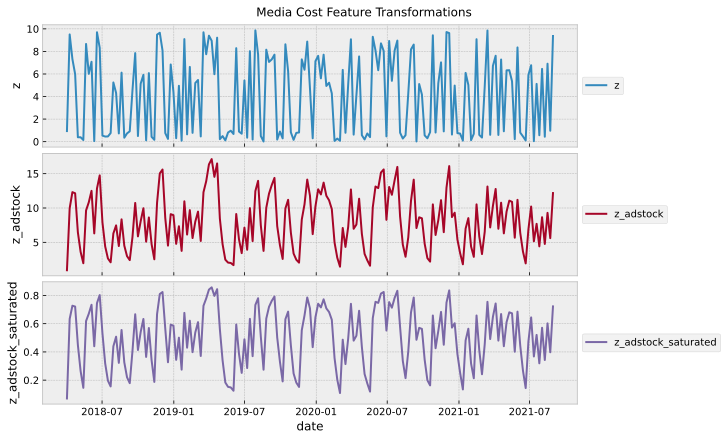

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")

features = ["z", "z_adstock", "z_adstock_saturated"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

- **Diminishing Returns Over Time**

Finally, we want to assume that the overall media efficiency decreases over time. We can do this by multiplying  `z_adstock_saturated` with a decreasing function. We would expect to recover the decreasing effect with Orbit's KTR model. Let us consider a rational function:

<Figure size 1000x600 with 1 Axes>

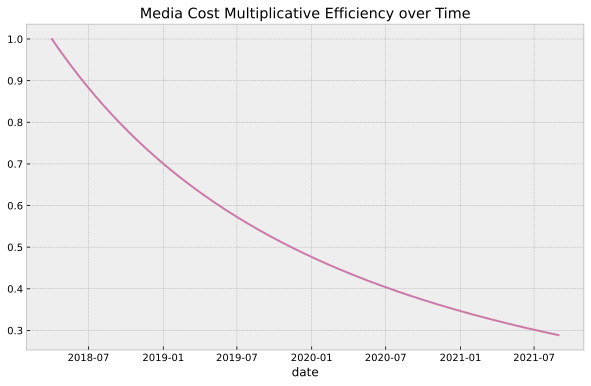

In [12]:
data_df["beta"] =  (np.arange(start=0.0, stop=1.0, step=1/n) + 1) ** (-1.8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="beta", color="C5", data=data_df, ax=ax)
ax.set(title="Media Cost Multiplicative Efficiency over Time", ylabel=None);

Next, we compute the product of `beta` and `z_adstock_saturated`:

In [13]:
data_df["z_effect"] = data_df["beta"] * data_df["z_adstock_saturated"]

<Figure size 1200x700 with 4 Axes>

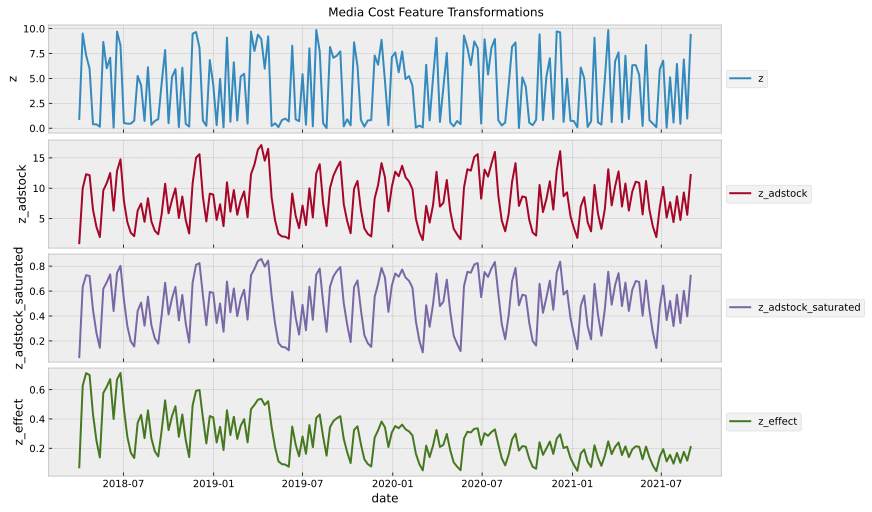

In [14]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=False,
    layout="constrained"
)

features = ["z", "z_adstock", "z_adstock_saturated", "z_effect"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

We can now plot the "true" saturation curves at yearly level based on the transformed data. We would like to recover the saturation effect. Note that we do not seed to expect a curve of the form $x\longmapsto (1 - e^{-\mu x}) / (1 + e^{-\mu x})$ necessarily as we have a non-trivial time component (still, this parametrization could be a good approximation). For now, we simply use a [`lowess`](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) fit.

<Figure size 685.25x600 with 1 Axes>

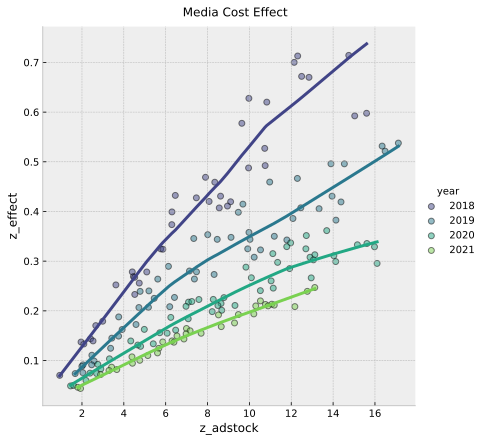

In [15]:
g = sns.lmplot(
    x="z_adstock",
    y="z_effect",
    hue="year",
    palette="viridis",
    lowess=True,
    scatter_kws={"edgecolor": "black", "alpha": 0.5},
    height=6,
    data=data_df
)
g.fig.suptitle("Media Cost Effect", y=1.02);

We can see from this plot that (1) the overall media efficiency is decaying over time and the (2) the saturation effect is present but not very strong.

Recall that for the model we will assume we have `z_adstock` and we would like to recover `z_effect`. Let us now plot the `effect ratio` defined by `z_effect` / `z_adstock`. We also smooth the curve (with a gaussian filter) to capture the overall trend. 

<Figure size 1000x600 with 1 Axes>

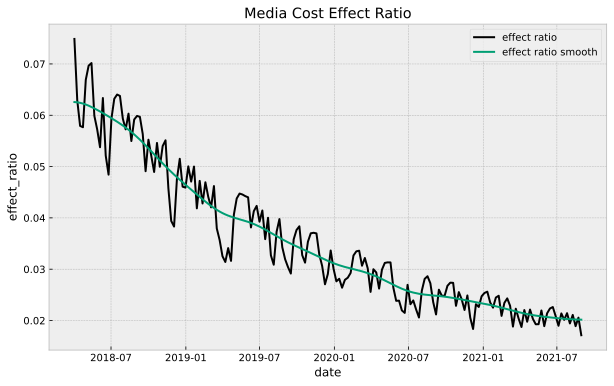

In [16]:
data_df.eval(expr="effect_ratio = z_effect / z_adstock", inplace=True)

data_df["effect_ratio_smooth"] = gaussian_filter(input=data_df["effect_ratio"], sigma=8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="effect_ratio", color="black", label="effect ratio", data=data_df, ax=ax)
sns.lineplot(x="date", y="effect_ratio_smooth", color="C7", label="effect ratio smooth", data=data_df, ax=ax)
ax.set(title="Media Cost Effect Ratio");

**Remark:** Note that we applied the saturation and diminishing returns transformations independently. We could have done it differently by simply making $\mu=\mu(t)$ time dependent in the `LogisticSaturationTransformer`. For example,

```python
mu = np.linspace(start=0.05, stop=0.1, num=n)[::-1] ** (1.25)
```

This is the original formulation of Uber's paper see section $2$ in [Edwin, Ng, et al. "Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling"](https://arxiv.org/abs/2106.03322). Some initial experiments show that ins this additive model structure, the saturation and diminishing returns transformations are well captured by the KTR model.

### Trend and Seasonality

Next, we add some additive trend and seasonal components. For the trend component we simple use a rational power law:

In [17]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10)**(1/4) - 1 

For the seasonal component we use combinations of Fourier modes:

In [18]:
data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
data_df["seasonality"] = 0.25 * (data_df["cs"] + data_df["cc"])

Let us plot the components:

<Figure size 1000x600 with 1 Axes>

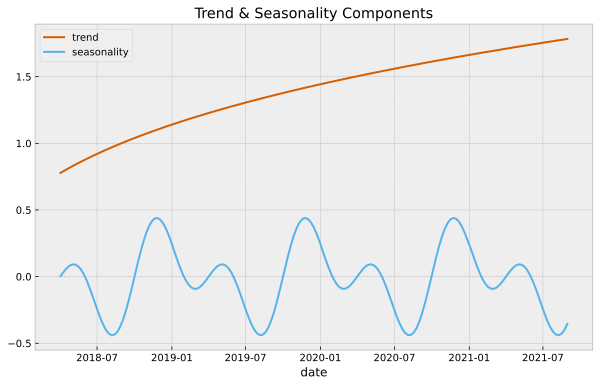

In [19]:

fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C4", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date", y="seasonality", color="C6", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel="");

### Target Variable: Sales

As a final step in the data generation process let us put everything together. First, we can add an intercept and generate gaussian noise:

In [20]:
np.random.seed(SEED)

data_df["intercept"] = 3.0
data_df["trend_plus_intercept"] = data_df["trend"] + data_df["intercept"]

# the noise variance is increasing to make sure the resulting time series has constant variance
sigma_epsilon = linspace = np.linspace(start=3e-2, stop=7e-2, num=n)
data_df["epsilon"] = np.random.normal(loc=0.0, scale=sigma_epsilon)

Now let us build our additive time series:

In [21]:
data_df.eval(expr="y = intercept + trend + seasonality + z_effect + epsilon", inplace=True)

We can now plot resulting time series:

<Figure size 1000x600 with 1 Axes>

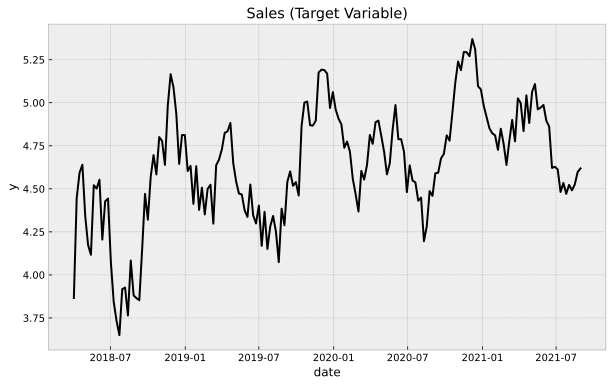

In [22]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax)
ax.set(title="Sales (Target Variable)");

Let us compare the generated data with `z_effect`, which is the true effect of media on sales, and `z_adstock`, which is the the regressor we want to use in our regression model.

<Figure size 1000x600 with 3 Axes>

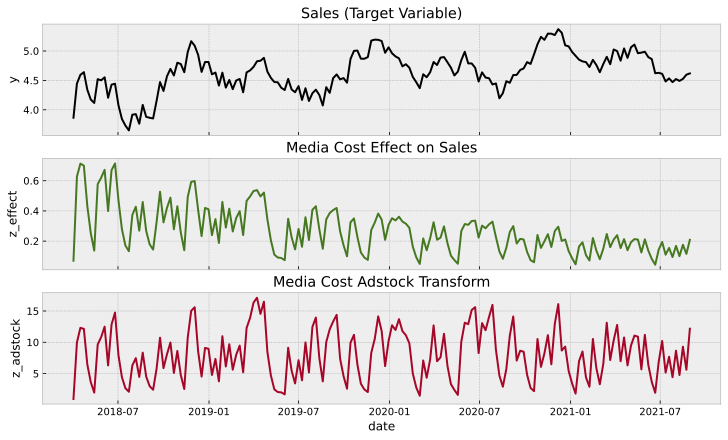

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=axes[0])
axes[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=axes[1])
axes[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z_adstock", color="C1", data=data_df, ax=axes[2])
axes[2].set(title="Media Cost Adstock Transform");

---
## Part II: Modeling

In this second part of the notebook we are going to fit two time series model: (1) a [Prophet](https://facebook.github.io/prophet/) model and (2) a KTR model. Even though we are mainly interested in the time varying coefficients provided by the KTR model, we start fit the Prophet model to get a baseline. 

### Prophet Model

The Prophet model is a good choice for time series with strong trend and seasonality patterns (see the great [documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api) and [this](https://juanitorduz.github.io/fb_prophet/) blog post for an introduction). However, the regression coefficients do not vary over time. We use the default MAP estimation method to fit the model (not full MCMC).

 - **Model Specification and Fit**

In [24]:
# set model parameters
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.add_regressor(name="z_adstock", mode="additive", standardize=False)
# fit model
prophet_model.fit(df=data_df.rename(columns={"date": "ds"}))
# generate predictions
prophet_pred_df = prophet_model.predict(df=data_df.rename(columns={"date": "ds"}))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2.76134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       706.748   0.000101469       371.094      0.4471      0.4471      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       707.846   8.93774e-05        629.32      0.2012      0.2012      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       708.939   7.79339e-05       180.234       1.195      0.1195      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       709.064   1.46823e-05       77.4373           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       709.135   2.21089e-06       90.9128   1.024e-08       0.001      665  LS failed, Hessian reset 
     499       709.201    2.4847e-05    

/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


First, let us see the model fit:

<Figure size 1000x600 with 1 Axes>

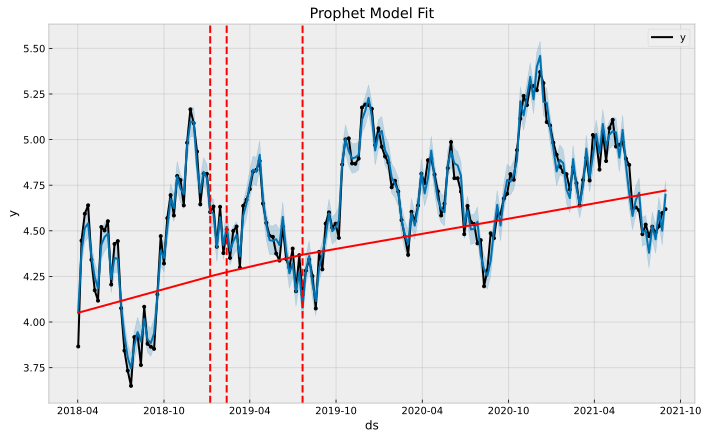

In [25]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", label="y", data=data_df, ax=ax)
fig = prophet_model.plot(fcst=prophet_pred_df, ax=ax)
a = add_changepoints_to_plot(ax=ax, m=prophet_model, fcst=prophet_pred_df)
ax.legend(loc="upper right")
ax.set(title="Prophet Model Fit");

- **Model Components**

The fit looks overall quite good. Now let us visualize the model predicted and true components:

/Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


<Figure size 900x900 with 3 Axes>

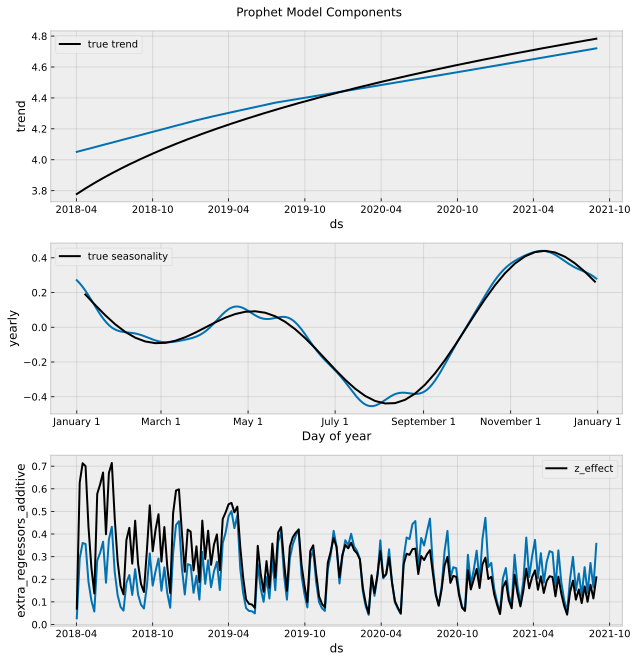

In [26]:
fig = prophet_model.plot_components(fcst=prophet_pred_df)

axes = fig.axes

sns.lineplot(
    x="ds",
    y="trend_plus_intercept",
    color="black",
    data=data_df.rename(columns={"date": "ds"}),
    label="true trend",
    ax=axes[0]
)
sns.lineplot(
    x="ds_1",
    y="seasonality",
    color="black",
    data=(
        data_df
        .rename(columns={"date": "ds"})
        .query("year == 2019")
        .assign(ds_1 = lambda x: x["ds"]  - pd.DateOffset(years=2))
    ),
    label="true seasonality",
    ax=axes[1]
)
sns.lineplot(
    x="ds",
    y="z_effect",
    color="black",
    data=data_df.rename(columns={"date": "ds"}),
    label="z_effect",
    ax=axes[2]
)
fig.suptitle("Prophet Model Components", y=1.02);


The trend and seasonal components seem to be well captured by the model. On the other hand, the model does not capture the effect of media on sales, as expected. 

- **Estimated Media Effect**

We can extract the estimated beta coefficient for `z_adstock` and compare it with the true value.

<Figure size 1000x600 with 1 Axes>

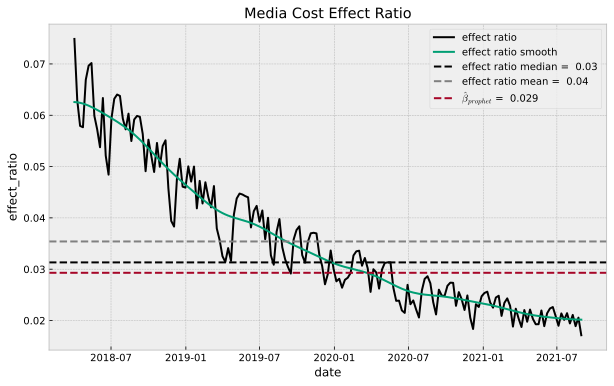

In [27]:
prophet_regressor_df = regressor_coefficients(m=prophet_model)
beta_hat_prophet = prophet_regressor_df.query("regressor == 'z_adstock'")["coef"].to_numpy()[0]

fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="effect_ratio",
    color="black",
    label="effect ratio",
    data=data_df,
    ax=ax
)
sns.lineplot(
    x="date",
    y="effect_ratio_smooth",
    color="C7",
    label="effect ratio smooth",
    data=data_df,
    ax=ax
)
ax.axhline(
    y=data_df["effect_ratio"].median(),
    color="black",
    linestyle="--",
    label=f"effect ratio median = {data_df['effect_ratio'].median(): 0.2f}"
)
ax.axhline(
    y=data_df["effect_ratio"].mean(),
    color="gray",
    linestyle="--",
    label=f"effect ratio mean = {data_df['effect_ratio'].mean(): 0.2f}"
)
ax.axhline(
    y=beta_hat_prophet,
    color="C1",
    linestyle="--",
    label="$\hat{\\beta}_{prophet}$ " + f"= {beta_hat_prophet: 0.3f}"
)
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect Ratio");

In this example we see that the estimated beta coefficient for `z_adstock` in the Prophet model is close to the median of the true time-varying beta coefficient expected from the data generation process.

### KTR Model

Now we fit the KTR model. We use the `pyro-svi` estimator which is a [Pyro](https://pyro.ai/)-based stochastic variational inference.

 - **Model Specification and Fit**

In [28]:
# define model parameters
date_col = "date"
response_col = "y"
regressor_col = ["z_adstock"]

ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    regression_knot_distance=12,
    prediction_percentiles=[2.5, 97.5],
    seasonality=[52.25],
    regressor_sign=["+"],
    seed=42,
    estimator='pyro-svi',
)
# fit model
ktr.fit(df=data_df)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:301 , samples:100 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100.
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 6607.5, scale = 0.10045
INFO:orbit:step  100 loss = 2.7757, scale = 0.60361
INFO:orbit:step  200 loss = -167.32, scale = 0.27316
INFO:orbit:step  300 loss = -171.84, scale = 0.24962


<orbit.forecaster.svi.SVIForecaster object at 0x7fb7064df640>

Let us generate predictions for the KTR model:

In [29]:
pred_df = ktr.predict(df=data_df, decompose=True)

<Figure size 1000x600 with 1 Axes>

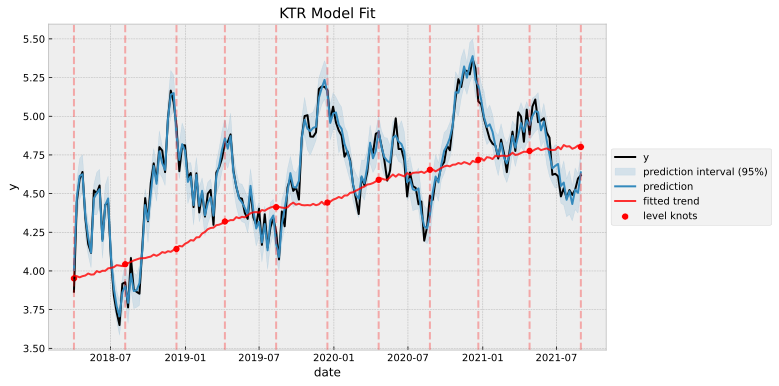

In [30]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", label="y", data=data_df, ax=ax)
ax.fill_between(
    x=pred_df["date"],
    y1=pred_df["prediction_2.5"],
    y2=pred_df["prediction_97.5"],
    color="C0",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(x="date", y="prediction", color="C0", label="prediction", data=pred_df, ax=ax)
sns.lineplot(
    x="date",
    y="trend",
    alpha=0.8,
    color="red",
    label="fitted trend",
    data=pred_df,
    ax=ax
)
sns.scatterplot(
    x="date",
    y="lev_knot",
    data=ktr.get_level_knots(),
    s=50,
    color="red",
    label="level knots",
    ax=ax
)
for row in ktr.get_level_knots().itertuples():
    ax.axvline(x=row.date, color="red", alpha=0.3, linestyle="--")


ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="KTR Model Fit");

We can get the complete posterior samples as follows:

In [31]:
for k, samples in ktr.get_posterior_samples().items():
    print(k, samples.shape)

lev_knot (100, 11)
lev (100, 179)
yhat (100, 179)
obs_scale (100,)
coef_knot (100, 16)
coef_init_knot (100,)
coef (100, 179)


- **Model Components**

Next, we can plot the fitted trend ans seasonal components:

<Figure size 1000x600 with 2 Axes>

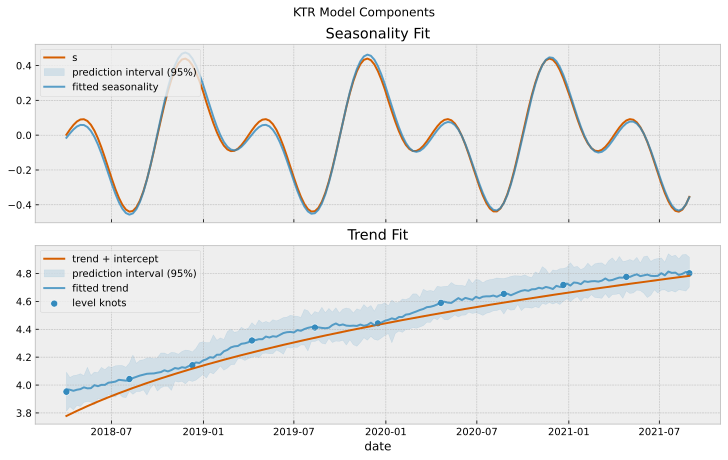

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, layout="constrained")

sns.lineplot(x="date",
    y="seasonality",
    color="C4",
    label="s",
    data=data_df,
    ax=ax[0]
)
ax[0].fill_between(
    x=pred_df["date"],
    y1=pred_df["seasonality_52.25_2.5"],
    y2=pred_df["seasonality_52.25_97.5"],
    color="C0",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(
    x="date",
    y="seasonality_52.25",
    alpha=0.8,
    color="C10",
    label="fitted seasonality",
    data=pred_df,
    ax=ax[0]
)
ax[0].legend(loc="upper left")
ax[0].set(title="Seasonality Fit", ylabel=None)

sns.lineplot(
    x=data_df["date"],
    y=data_df["trend"] + data_df["intercept"],
    color="C4",
    label="trend + intercept",
    ax=ax[1]
)
ax[1].fill_between(
    x=pred_df["date"],
    y1=pred_df["trend_2.5"],
    y2=pred_df["trend_97.5"],
    color="C0",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(
    x="date",
    y="trend",
    alpha=0.8,
    color="C0",
    label="fitted trend",
    data=pred_df,
    ax=ax[1]
)
sns.scatterplot(
    x="date",
    y="lev_knot",
    data=ktr.get_level_knots(),
    s=50,
    label="level knots",
    ax=ax[1]
)
ax[1].legend(loc="upper left")
ax[1].set(title="Trend Fit", ylabel=None)
fig. suptitle("KTR Model Components", y=1.04);

The fit looks a bit better than the prophet model (specially the trend component). 

- **Estimated Media Effect**

Now let us extract the beta coefficient for `z_adstock`:

In [33]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

From the estimated beta coefficient we can compute the estimated media effect on sales:

In [34]:
for df in coef_mid, coef_lower, coef_upper:
    df["z_effect_pred"] = df["z_adstock"] * data_df["z_adstock"]
    df["year"] = df["date"].dt.year # this is a feature used later for viz purposes

We can now compare it with the true `effect ratio`:

<Figure size 1100x800 with 3 Axes>

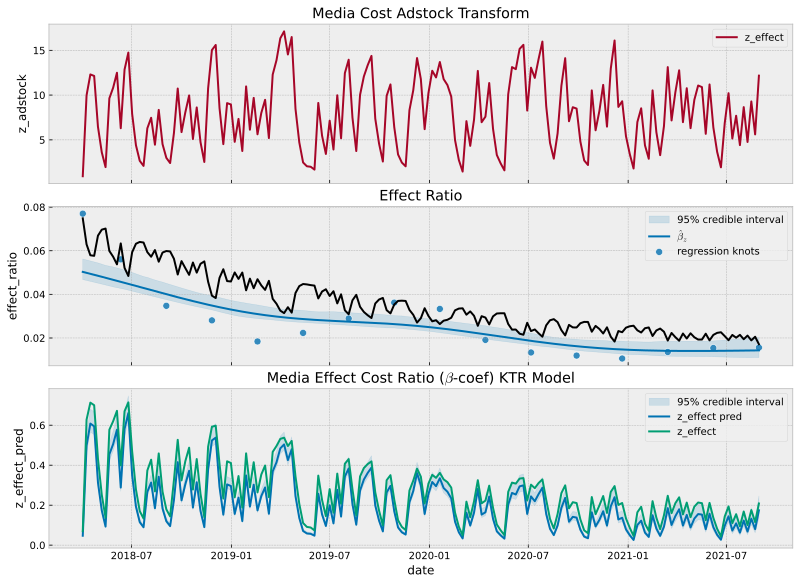

In [35]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(11, 8),
    sharex=True,
    sharey=False,
    layout="constrained"
)

sns.lineplot(
    x="date",
    y="z_adstock",
    color="C1",
    label="z_effect",
    data=data_df,
    ax=ax[0]
)
ax[0].set(title="Media Cost Adstock Transform")

sns.lineplot(
    x="date",
    y="effect_ratio",
    color="black",
    data=data_df,
    ax=ax[1]
)
ax[1].fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_adstock"],
    y2=coef_upper["z_adstock"],
    color="C9",
    label="95% credible interval",
    alpha=0.15
)
sns.lineplot(
    x="date",
    y="z_adstock",
    color="C9",
    label="$\hat{\\beta}_{z}$",
    data=coef_mid,
    ax=ax[1]
)
sns.scatterplot(
    x="date",
    y="z_adstock",
    data=ktr.get_regression_coef_knots(),
    s=50,
    label="regression knots",
    ax=ax[1]
)
ax[1].set(title="Effect Ratio")

ax[2].fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_effect_pred"],
    y2=coef_upper["z_effect_pred"],
    color="C9",
    label="95% credible interval",
    alpha=0.15
)
sns.lineplot(x="date",
    y="z_effect_pred",
    color="C9",
    label="z_effect pred",
    data=coef_mid,
    ax=ax[2]
)
sns.lineplot(x="date",
    y="z_effect",
    color="C7",
    label="z_effect",
    data=data_df,
    ax=ax[2]
)
ax[2].set(title="Media Effect Cost Ratio ($\\beta$-coef) KTR Model");

The KTR model captures the overall diminishing returns effect over time. Let us now zoom in and compare the effect estimation of the Prophet and KTR models:

<Figure size 1000x600 with 1 Axes>

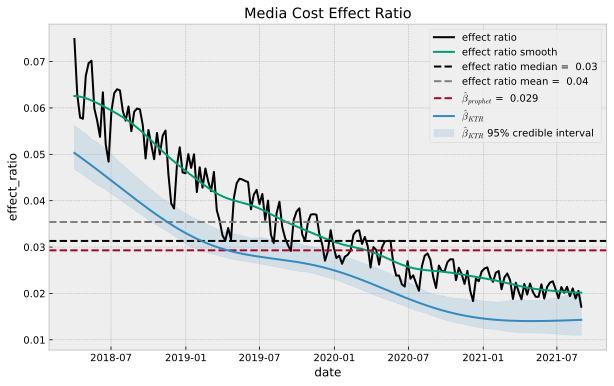

In [36]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="effect_ratio",
    color="black",
    label="effect ratio",
    data=data_df,
    ax=ax
)
sns.lineplot(
    x="date",
    y="effect_ratio_smooth",
    color="C7",
    label="effect ratio smooth",
    data=data_df,
    ax=ax
)
ax.axhline(
    y=data_df["effect_ratio"].median(),
    color="black",
    linestyle="--",
    label=f"effect ratio median = {data_df['effect_ratio'].median(): 0.2f}"
)
ax.axhline(
    y=data_df["effect_ratio"].mean(),
    color="gray",
    linestyle="--",
    label=f"effect ratio mean = {data_df['effect_ratio'].mean(): 0.2f}"
)
ax.axhline(
    y=beta_hat_prophet,
    color="C1",
    linestyle="--",
    label="$\hat{\\beta}_{prophet}$ " + f"= {beta_hat_prophet: 0.3f}"
)
sns.lineplot(
    x="date",
    y="z_adstock",
    color="C0",
    label="$\hat{\\beta}_{KTR}$",
    data=coef_mid,
    ax=ax
)
ax.fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_adstock"],
    y2=coef_upper["z_adstock"],
    color="C0",
    label="$\hat{\\beta}_{KTR}$ 95% credible interval",
    alpha=0.15
)
ax.legend(loc="upper right")
ax.set(title="Media Cost Effect Ratio");

It is clear that the KTR model flexibility for time-varying coefficients outperforms the Prophet model base model. Nevertheless, the estimated effect by the KTR model is a bit lower than the true effect.

- **Saturation Effect**

Finally, let us see how much we can recover the saturation effect:

<Figure size 900x800 with 1 Axes>

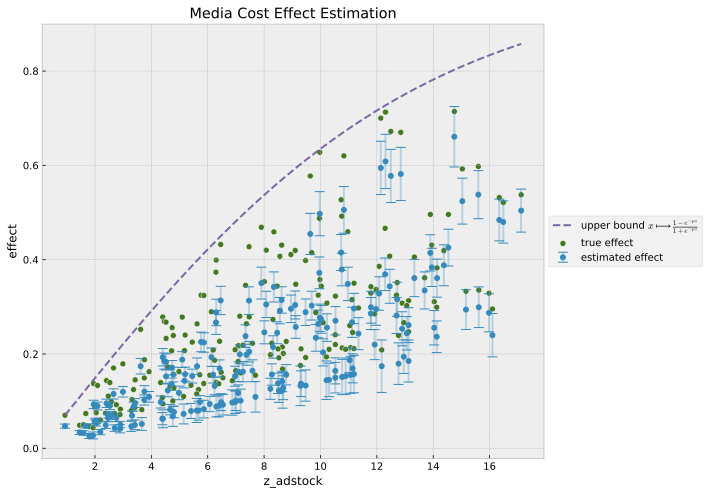

In [37]:
fig, ax = plt.subplots(figsize=(9, 8))

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=coef_mid["z_effect_pred"], 
    yerr=(coef_upper["z_effect_pred"] - coef_lower["z_effect_pred"]) / 2,
    fmt='o',
    ms=5,
    capsize=5,
    label="estimated effect",
)
[bar.set_alpha(0.3) for bar in bars]


latex_function = r"$x\longmapsto \frac{1 - e^{-\mu z}}{1 + e^{-\mu z}}$"
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label="upper bound " + latex_function,
    linestyle="--",
    data=data_df,
    ax=ax
)
sns.scatterplot(
    x="z_adstock",
    y="z_effect",
    color="C3",
    label="true effect",
    data=data_df,
    ax=ax
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title="Media Cost Effect Estimation", ylabel="effect");

The dashed purple curve denotes the true saturation curve from the data generation process. Recall that the true effect was assumed to be product of the `z_adstock_saturated` by a decreasing function $\beta = \beta(t) \subset [0, 1]$. These true estimated effects are the green points, which are of course below the dashed purple curve since the function $\beta(t)$ is in particular less or equal than one. The blue points (and the credible intervals) denote the KTR estimated media effect on sales. From this plot we can not easily infer the saturation effect. The reason is that the time component is not explicitly represented in this plot. Let us split it by year:

<Figure size 1000x900 with 4 Axes>

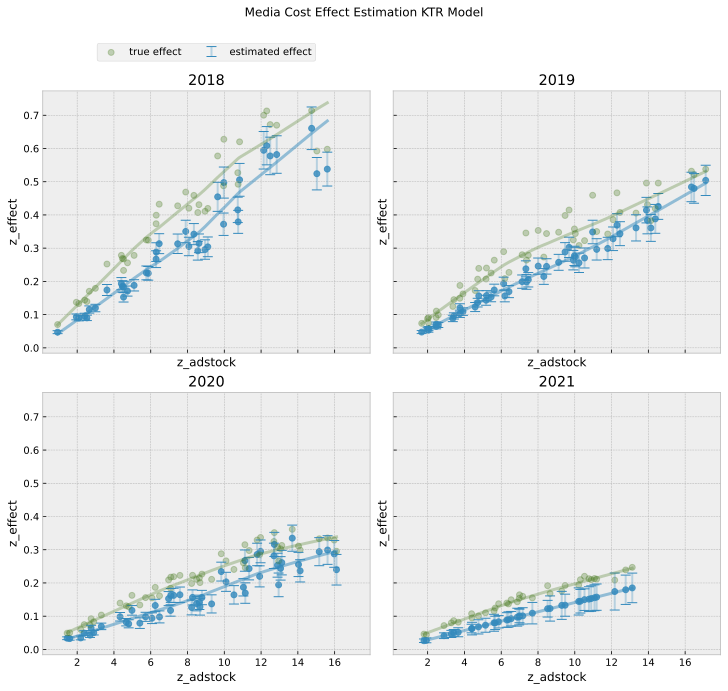

In [38]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 9), 
    sharex=True,
    sharey=True,
    layout="constrained"
)

axes = axes.flatten()

for i, year in enumerate(data_df["year"].sort_values().unique()):
    
    ax = axes[i]
    mask = f"year == {year}"

    markers, caps, bars = ax.errorbar(
        x=data_df.query(mask)["z_adstock"], 
        y=coef_mid.query(mask)["z_effect_pred"], 
        yerr=(coef_upper.query(mask)["z_effect_pred"] - coef_lower.query(mask)["z_effect_pred"]) / 2,
        fmt='o',
        ms=0,
        capsize=5,
        label="estimated effect",
    )
    [bar.set_alpha(0.3) for bar in bars]

    sns.regplot(
        x=data_df.query(mask)["z_adstock"], 
        y=coef_mid.query(mask)["z_effect_pred"], 
        lowess=True,
        color="C0",
        line_kws={"alpha": 0.5},
        ax=ax
    )

    sns.regplot(
        x="z_adstock",
        y="z_effect",
        lowess=True,
        color="C3",
        label="true effect",
        data=data_df.query(mask),
        scatter_kws={"alpha": 0.3},
        line_kws={"alpha": 0.3},
        ax=ax
    )
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    else:
        ax.legend().remove()
    ax.set(title=f"{year}")
    
fig.suptitle("Media Cost Effect Estimation KTR Model", y=1.05);

In this plot we also see that the KTR is underestimating the media effect on sales most of the time. For both, the true and estimated effects we are using a `lowess` interpolation. In this example, the true saturation effect is by itself not very strong. The KTR model does show a non-linear relation as seen by the `lowess` fit. The year $2020$ shows the closes fit.